In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For i/o paths
from pathlib import Path

import m3code
import analysis
import models

# For map visualization
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mapviz

# For manipulating colors
import matplotlib.colors as mplcolors

# For manipulating lines
from matplotlib.collections import LineCollection

In [2]:
# Plot settings
plt.rcParams['font.family'] = ['sans-serif', 'serif']
plt.rcParams["font.sans-serif"] = ['Helvetica']
plt.rcParams['font.serif'] = ['Palatino']
SMALL_FONT_SIZE = 9
MEDIUM_FONT_SIZE = 11
LARGE_FONT_SIZE = 12.5
PANEL_LABEL_SIZE = 16
PANEL_LABEL_FONT = 'DejaVu Sans'
plt.rcParams.update({'font.size': MEDIUM_FONT_SIZE})

In [3]:
def dms2dd(dms):
    '''Convert the degrees, minutes, seconds notation to decimal degrees'''
    return dms[0] + dms[1] / 60 + dms[2] / 3600

# Reachable extreme points of Japan
east_ext = dms2dd((145, 48, 58))
west_ext = dms2dd((122, 56, 1))
south_ext = dms2dd((24, 2, 59))
north_ext = dms2dd((45, 31, 22))

center_lon = dms2dd((139, 44, 28))
center_lat = dms2dd((35, 39, 29))
lon_diff = east_ext - west_ext
lat_diff = north_ext - south_ext
extent = (west_ext-lon_diff*0.05, east_ext+lon_diff*0.05, 
          south_ext-lat_diff*0.05, north_ext+lat_diff*0.05)

lambert_area_proj = ccrs.LambertAzimuthalEqualArea(
    central_longitude=center_lon, 
    central_latitude=center_lat)

In [4]:
# Data paths
import json
data_dir = Path().resolve().parent / 'original' / 'selected_geotagged_tweet_data'
with (data_dir / 'file_names.json').open(mode='r') as f:
    file_names_dict = json.load(f)
all_file = data_dir / file_names_dict['all']['filename']
toponym_en = 'Fukuoka'
toponym = file_names_dict[toponym_en]['japanese']
topo_file = data_dir / file_names_dict[toponym_en]['filename']

figdir = Path().resolve().parent / 'figure'

In [5]:
# Load data
all_df = pd.read_csv(all_file, dtype={'m3code':str})
if not all_df['m3code'].is_unique:
    print('Total data: \"m3code\" is not unique.')
all_df[['latitude', 'longitude']] = m3code.latlon(all_df)

topo_df = pd.read_csv(topo_file, dtype={'m3code':str})
if not topo_df['m3code'].is_unique:
    print(f'{toponym_en} data: \"m3code\" is not unique.')

target_all_df = pd.merge(topo_df, all_df, on='m3code', how='left', suffixes=['_target', ''])\
    [['m3code', 'tweetcount_target', 'tweetcount', 'area', 'latitude', 'longitude']]\
    .rename(columns={'tweetcount': 'tweetcount_all'})

In [6]:
target_all_df

,m3code,tweetcount_target,tweetcount_all,area,latitude,longitude
0,34306086,1,1,1.180676,23.237500,130.08125
1,36225734,5,1349,1.169969,24.445833,122.93125
2,36230672,1,660,1.173422,24.062500,123.78125
3,36233720,1,1692,1.171552,24.270833,123.88125
4,36233799,1,2034,1.171026,24.329167,123.99375
...,...,...,...,...,...,...
27586,68410575,1,5838,0.906572,45.395833,141.69375
27587,68410576,1,2726,0.906572,45.395833,141.70625
27588,68410594,1,3390,0.906308,45.412500,141.68125
27589,68411504,3,2792,0.906176,45.420833,141.68125


In [7]:
data_all = target_all_df['tweetcount_all'].to_numpy()
data_word = target_all_df['tweetcount_target'].to_numpy()
data_area = target_all_df['area'].to_numpy()
data_lon = target_all_df['longitude'].to_numpy()
data_lat = target_all_df['latitude'].to_numpy()
densities_target = data_word / data_area
densities_all = (all_df['tweetcount'] / all_df['area']).to_numpy()
data_ratio = data_word / data_all
xmesh, ymesh, zmesh, dlevels = \
    models.data_contours(data_all, data_word, log_scale=True)
target_all_df['distance_from_center'] = analysis.distance_from_center(target_all_df)

In [8]:
city_coords = {'Tokyo': (139.69, 35.69),
               'Osaka': (135.50, 34.69),
               'Fukuoka': (130.40, 33.59)}

In [9]:
def plot_map_with_toponyms(ax, coords, *, 
                           text_offset_dict, text_arrow_vec, text_offset_coeff, toponym_fontsize):
    for name, coord in coords.items():
        offset_len = text_offset_dict[name]
        offset = offset_len * text_arrow_vec
        text_ha = 'left' if offset_len > 0 else 'right'
        arrow_offset = text_offset_coeff * ((offset_len > 0) * 2 - 1) * text_arrow_vec
        ax.text(coord[0]+offset[0], coord[1]+offset[1], 
                name, transform=ccrs.PlateCarree(), 
                fontsize=toponym_fontsize, color='black', ha=text_ha, va='center')
        lc = LineCollection([[
            (coord[0]+offset[0]-arrow_offset[0], 
             coord[1]+offset[1]-arrow_offset[1]), 
            (coord[0]+arrow_offset[0], 
             coord[1]+arrow_offset[1])]], 
            transform=ccrs.PlateCarree(), color='black', linewidth=0.8)
        ax.add_collection(lc)

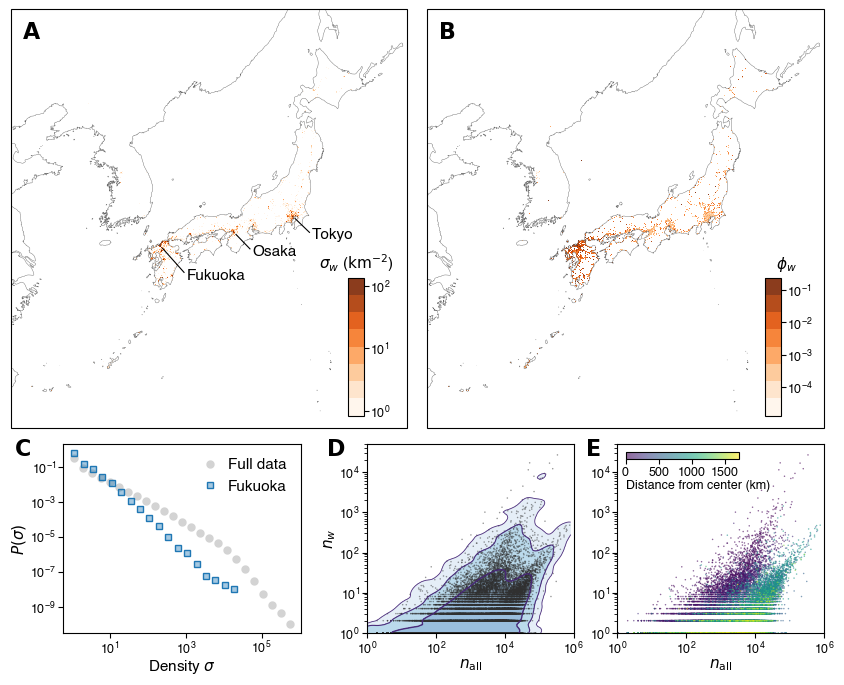

In [10]:
fig = plt.figure(figsize=(10.5, 7.5))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 0.4], hspace=-0.25)

# Maps
map_axes = subfigs[0].subplot_mosaic(
    """
    AB
    """, 
    per_subplot_kw={
        ("A", "B"): {"projection": lambert_area_proj},
    }, 
    gridspec_kw={
        "wspace": 0.05,
    }
)

# A, B
for data_val, cblabel, panel_label in zip([densities_target, data_ratio],
                                          [r'$\sigma_w$ ($\mathrm{km}^{-2}$)', r'$\phi_w$'],
                                          ['A', 'B']):
    ax = map_axes[panel_label]
    norm = mplcolors.LogNorm(vmax=np.quantile(data_val, 0.99))
    cmap = plt.get_cmap('Oranges', 8)
    map_data = mapviz.MapVisualizer(fig, extent=extent, projection=lambert_area_proj, ax=ax, lw=0.3, color='dimgrey', resolution='10m')
    map_data.visualize(data_lon, data_lat, data_val, cmap=cmap, norm=norm, size=0.04, marker=',', alpha=0.9)
    cb = map_data.add_colorbar(orientation='vertical')
    cb.ax.tick_params(labelsize=SMALL_FONT_SIZE, pad=1)
    cb.ax.minorticks_off()
    cb.ax.set_yticks(np.power(10, np.arange(np.ceil(np.log10(data_val[data_val > 0].min())), 
                                            np.floor(np.log10(np.quantile(data_val, 0.99))) + 1)))
    labelpad = 2 if panel_label == 'A' else -11
    cb.set_label(cblabel, rotation=0, va='bottom', y=1.03, labelpad=labelpad)
    ax.text(0.03, 0.93, panel_label, transform=ax.transAxes, fontsize=PANEL_LABEL_SIZE, weight='bold', font=PANEL_LABEL_FONT)

    text_offset = {'Tokyo': 0.2, 'Osaka': 0.2, 'Fukuoka': 0.2}

    if panel_label == 'A':
        plot_map_with_toponyms(ax, city_coords,
                                 text_offset_dict={'Tokyo': 1.4, 'Osaka': 1.4, 'Fukuoka': 2},
                                 text_arrow_vec=np.array([1, -0.8]),
                                 text_offset_coeff=0.16,
                                 toponym_fontsize=MEDIUM_FONT_SIZE)

# Scatter plots
shift_x_wylabel = 0.18
shift_x_woylabel = 0.1
third_row_width = (1 - shift_x_wylabel) / (1 - shift_x_woylabel)
dist_axes = subfigs[1].subplot_mosaic(
    """
    CDE
    """, 
    width_ratios=[1.15, 1, third_row_width],
    per_subplot_kw={
        ("D", "E"): {"xscale": "log", "yscale": "log", 
                     "xlim": (1, 1E6), "ylim": (1, 5E4)},
    },
    gridspec_kw={
        "wspace": 0.08,
    }
)

# C
panel_label = 'C'
ax = dist_axes[panel_label]
analysis.plot_single_histogram(ax, densities_all, numbins=25, 
                               xscale='log', yscale='log', discrete=False, 
                               marker='o', ms=5, ls='', color='lightgrey', label='Full data')
analysis.plot_single_histogram(ax, densities_target, numbins=18, 
                               xscale='log', yscale='log', discrete=False, 
                               marker='s', ms=5, ls='', 
                               mfc=mplcolors.to_rgba('tab:blue', alpha=0.4), 
                               mec='tab:blue', mew=1, 
                               label=toponym_en)
ax.set_xlabel('Density ' + r'$\sigma$', labelpad=0.5)
ax.set_ylabel(r'$P(\sigma)$', labelpad=1.5)
ax.legend(frameon=False, fontsize=MEDIUM_FONT_SIZE, handletextpad=0.2)
ax.text(-0.2, 0.94, panel_label, transform=ax.transAxes, fontsize=PANEL_LABEL_SIZE, weight='bold', font=PANEL_LABEL_FONT)
pos1 = ax.get_position()
pos2 = [pos1.x0 + pos1.width*shift_x_wylabel, pos1.y0, pos1.width*(1-shift_x_wylabel), pos1.height]
ax.set_position(pos2)

sorted_df = target_all_df.sort_values(by=['distance_from_center'])
data_all = sorted_df['tweetcount_all'].to_numpy()
data_word = sorted_df['tweetcount_target'].to_numpy()
data_dist = sorted_df['distance_from_center'].to_numpy()

# D
panel_label = 'D'
ax = dist_axes[panel_label]
nlevels = len(dlevels) + 1
ax.contourf(xmesh, ymesh, zmesh,
            levels=np.append(dlevels, np.max(zmesh)),
            colors=[plt.colormaps['Blues']((i+1)/nlevels) for i in range(nlevels)], alpha=0.45)
ax.scatter(data_all, data_word, s=1.2, c='#303030', marker='o', edgecolors='none', alpha=0.5)
ax.contour(xmesh, ymesh, zmesh, levels=np.append(dlevels, np.max(zmesh)), 
           colors='#482475', alpha=0.95, linewidths=[0.6, 0.8, 1])


ax.set_ylabel(r'$n_w$', labelpad=1)
ax.text(-0.19, 0.94, panel_label, transform=ax.transAxes, fontsize=PANEL_LABEL_SIZE, weight='bold', font=PANEL_LABEL_FONT)
pos1 = ax.get_position()
pos2 = [pos1.x0 + pos1.width*shift_x_wylabel, pos1.y0, pos1.width*(1-shift_x_wylabel), pos1.height]
ax.set_position(pos2)

# E
panel_label = 'E'
ax = dist_axes[panel_label]
im = ax.scatter(data_all, data_word, c=data_dist, s=1.2, marker='o', edgecolors='none', 
                alpha=0.6, cmap='viridis')
cax = ax.inset_axes([0.04, 0.92, 0.55, 0.04])
cb = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[0, 500, 1000, 1500])
cb.set_label('Distance from center (km)', fontsize=SMALL_FONT_SIZE, x=0, ha='left', labelpad=0.7)
cb.ax.tick_params(pad=1.5, labelsize=SMALL_FONT_SIZE)
ax.text(-0.15, 0.94, panel_label, transform=ax.transAxes, fontsize=PANEL_LABEL_SIZE, weight='bold', font=PANEL_LABEL_FONT)
pos1 = ax.get_position()
pos2 = [pos1.x0 + pos1.width*shift_x_woylabel, pos1.y0, pos1.width*(1-shift_x_woylabel), pos1.height]
ax.set_position(pos2)

for ax in dist_axes.values():
    ax.tick_params(axis='both', pad=1.5, labelsize=SMALL_FONT_SIZE)

for ax in (dist_axes['D'], dist_axes['E']):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=1, right=1E6)
    ax.set_ylim(bottom=1, top=5E4)
    ax.set_xlabel(r'$n_\mathrm{all}$', labelpad=0.5)

In [11]:
fig.savefig(figdir / f'toponym_vs_all_{toponym_en}.png', dpi=350, bbox_inches='tight')